In [19]:
import streamlit as st
import pandas as pd
from collections import defaultdict
from google.cloud import firestore
from google.oauth2 import service_account
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# Connection to firebase
fb_credentials = st.secrets["firebase"]
creds = service_account.Credentials.from_service_account_info(fb_credentials)
db = firestore.Client(credentials=creds, project="feature-annotation")

In [3]:
# Annotation counter 
stats = db.collection("stats").stream()
cnt_dict = defaultdict(list)
for stat in stats:
    cnt = stat.to_dict()["annotation_count"]
    cnt_dict[cnt].append(stat.id)

for k, v in cnt_dict.items():
    print(f'{k} annotations: {len(v)} samples')

2 annotations: 68 samples
1 annotations: 74 samples
3 annotations: 1 samples


In [4]:
# Load annotations and preprocess
annotations = db.collection("annotations").stream()
df = pd.DataFrame([a.to_dict() for a in annotations])

df['user_timestamp'] = pd.to_datetime(df['user_timestamp'], unit='s')
df = df.replace('Please', pd.NA)

df.head()

,user_label,sample_id,user_complexity,user_name,user_timestamp,user_interp,user_notes,component_layer_idx,component_set_name,component_idx,component_submodule_type,component_training_run_name
0,have had be not,55,<NA>,Michael Lan,2024-03-15 14:17:07.180920064,25,,4,dense_random,495,mlp,10_32768
1,three letter words,116,25,Michael Lan,2024-03-15 14:17:28.120760320,25,,0,dense_RC,17,resid,10_32768
2,contact email,92,50,Michael Lan,2024-03-15 14:18:08.658583040,100,,3,sparse_BiB,31182,resid,10_32768
3,packages modes,137,100,Michael Lan,2024-03-15 14:19:18.273680128,25,,4,sparse_RC,11586,resid,10_32768
4,no common theme,31,100,Michael Lan,2024-03-15 14:20:09.663895296,0,,4,sparse_RC,3982,attn,10_32768


In [5]:
df.user_interp.isna().sum()

4

Dropping 4 rows with missing user_interp


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_93204/2311903348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interp['user_interp'] = df_interp['user_interp'].astype(float)


<Axes: title={'center': 'Mean interpretability score by component_set_name'}, xlabel='component_set_name', ylabel='Mean interpretability score in %'>

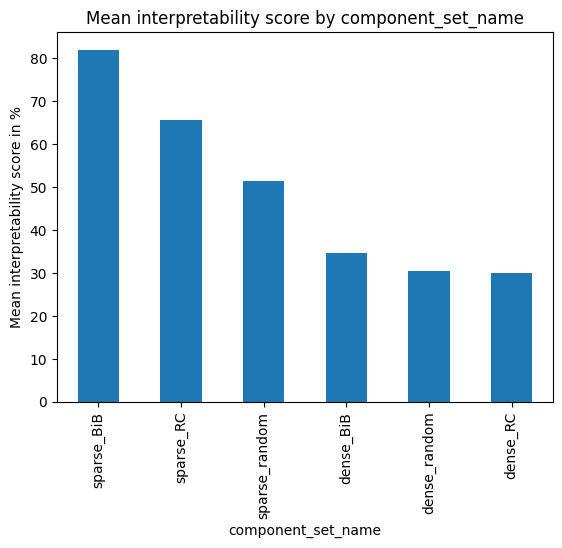

In [6]:
# Table of mean user_interp score by component_set_name
print(f'Dropping {df.user_interp.isna().sum()} rows with missing user_interp')
df_interp = df.dropna(subset=['user_interp'])
df_interp['user_interp'] = df_interp['user_interp'].astype(float)
df_interp.groupby('component_set_name')['user_interp'].mean().sort_values(ascending=False).plot(kind='bar', ylabel="Mean interpretability score in %", title="Mean interpretability score by component_set_name")

Component set: dense_random
30.571428571428573
28.121883580842407


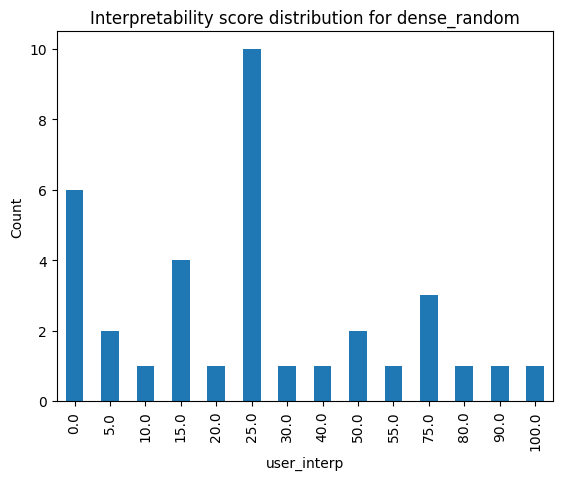

Component set: dense_RC
30.0
30.05741632047021


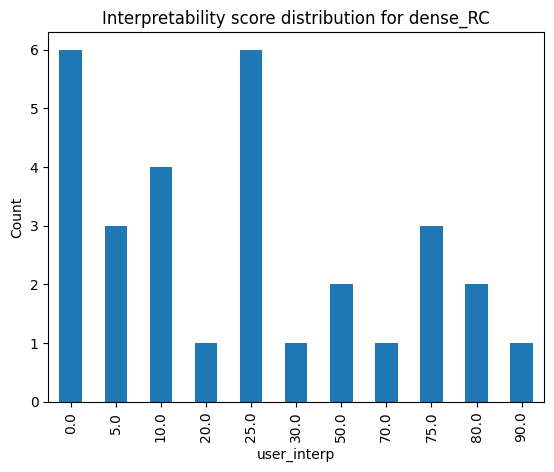

Component set: sparse_BiB
82.02702702702703
24.56452555853493


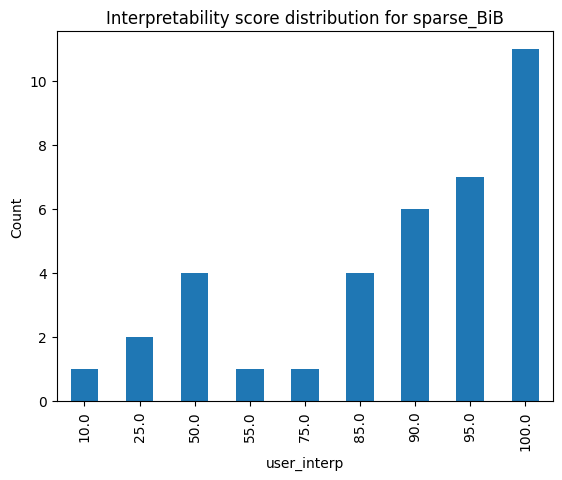

Component set: sparse_RC
65.57142857142857
31.733528116531403


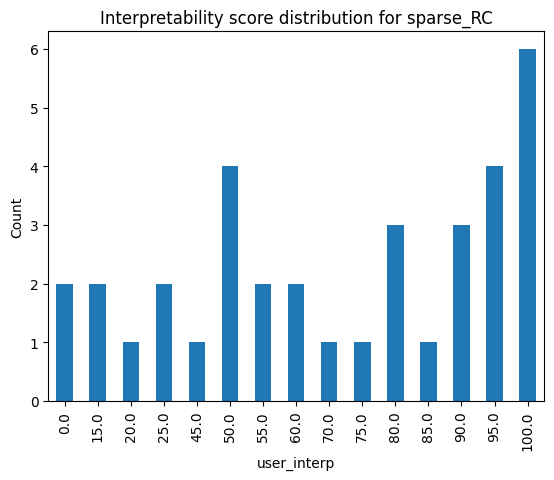

Component set: sparse_random
51.3235294117647
37.985420319679825


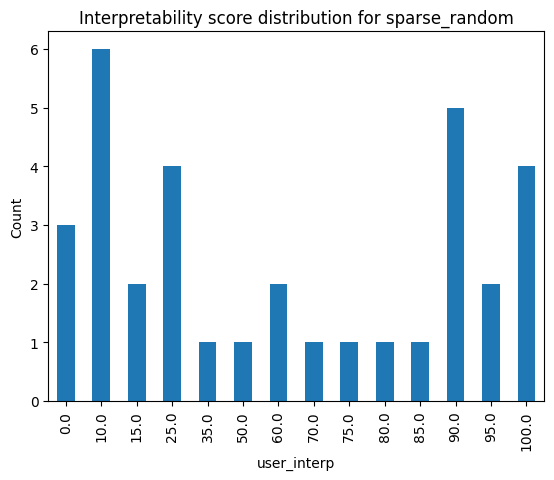

Component set: dense_BiB
34.705882352941174
32.495714786735974


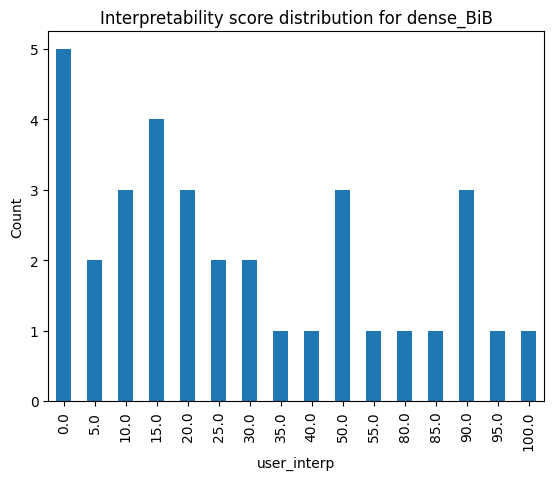

In [22]:
for i in df_interp['component_set_name'].unique():
    print(f'Component set: {i}')
    dfg = df_interp[df_interp['component_set_name'] == i]
    print(dfg['user_interp'].mean())
    print(dfg['user_interp'].std())
    dfg.groupby('user_interp')['user_interp'].count().plot(kind='bar', ylabel="Count", title=f"Interpretability score distribution for {i}")
    plt.show()


In [10]:
df_interp.groupby('component_set_name')['user_interp'].std().sort_values(ascending=False)

component_set_name
sparse_random    37.985420
dense_BiB        32.495715
sparse_RC        31.733528
dense_RC         30.057416
dense_random     28.121884
sparse_BiB       24.564526
Name: user_interp, dtype: float64

### User annotation times

In [22]:
# Check timestamps by user
df.user_name.value_counts()

Michael Lan                141
cocolugoj                   29
can focused                 25
Luhanm                       6
Can                          4
no need for payment : )      2
sdfg                         2
Name: user_name, dtype: int64

Text(0.5, 1.0, "Can's annotation timestamps")

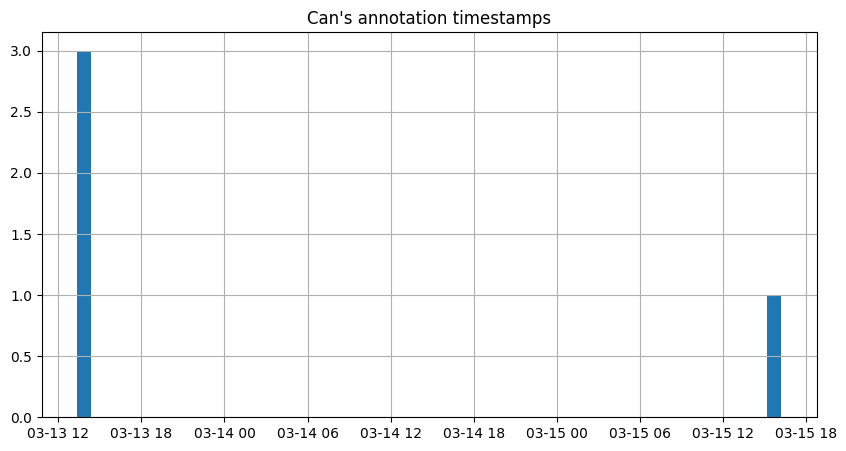

In [23]:
user = "Can"
fig = df[df.user_name == user].user_timestamp.hist(bins=50, xlabelsize=10, ylabelsize=10, figsize=(10,5))
fig.set_title(f"{user}'s annotation timestamps")
# df[df.user_name == "cocolugoj"].user_timestamp.dt.hour.hist(bins=50, xlabelsize=10, ylabelsize=10, figsize=(10,5))

### Inter- annotator agreement

In [24]:
cnt_dict_rev = defaultdict(list)
for k in cnt_dict.keys():
    for v in cnt_dict[k]:
        cnt_dict_rev[v].append(k)
df['sample_cnt'] = [cnt_dict_rev[sample_id][0] for sample_id in df.sample_id]

In [63]:
# Calculate the Inter-annotator agreement using pearson correlation for all components which were labeled twice and for each component_set_name separately
df = df.dropna(subset=['user_interp'])
df['user_interp'] = df['user_interp'].astype(float)
df['sample_id'] = df['sample_id'].astype(float)
df = df[df.sample_cnt == 2]
print(f'Pearson correlation of components labeled twice per component set\n')
for comp in sorted(df['component_set_name'].unique()):
    dfg = df[df["component_set_name"] == comp]
    dfg = dfg.sort_values(by=['sample_id'])
    annotations1 = dfg.iloc[::2].reset_index(drop=True)
    annotations2 = dfg.iloc[1::2].reset_index(drop=True)
    print(f'{comp}:\tr = {annotations1.user_interp.corr(annotations2.user_interp):.2f}  (n={len(annotations1)})')


Pearson correlation of components labeled twice per component set

dense_BiB:	r = 0.13  (n=11)
dense_RC:	r = 0.61  (n=10)
dense_random:	r = -0.12  (n=12)
sparse_BiB:	r = 0.61  (n=12)
sparse_RC:	r = 0.19  (n=13)
sparse_random:	r = 0.69  (n=9)


In [28]:
df[df.user_name == "cocolugoj"][df.component_set_name == "sparse_RC"]

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_93204/1589230382.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.user_name == "cocolugoj"][df.component_set_name == "sparse_RC"]


,user_label,sample_id,user_complexity,user_name,user_timestamp,user_interp,user_notes,component_layer_idx,component_set_name,component_idx,component_submodule_type,component_training_run_name
41,politics,66,90,cocolugoj,2024-03-15 14:50:02.575330048,55,,4,sparse_RC,14719,resid,10_32768
67,"tracks token coming after ""the""",137,95,cocolugoj,2024-03-15 15:03:20.194050816,70,,4,sparse_RC,11586,resid,10_32768
72,subject recurrence,94,<NA>,cocolugoj,2024-03-15 15:07:30.508875264,<NA>,almost like a memory component that triggers m...,2,sparse_RC,9960,resid,10_32768
79,news on elections,83,15,cocolugoj,2024-03-15 15:09:39.727098112,80,,4,sparse_RC,8913,resid,10_32768
90,everyone/anyone/consumer tokens,126,85,cocolugoj,2024-03-15 15:27:52.420082176,55,,5,sparse_RC,9376,attn,10_32768
93,things related to games or stories,46,75,cocolugoj,2024-03-15 15:38:26.033020928,60,,5,sparse_RC,19066,resid,10_32768
185,tracks changes in subject,69,80,cocolugoj,2024-03-15 12:35:27.531413248,25,,1,sparse_RC,15769,resid,10_32768
